<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/pytorch_recon/torch_forward_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mbirjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.8/323.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 39.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import jax.numpy as jnp
import mbirjax

# Choose the geometry type
geometry_type = 'parallel'  # 'cone' or 'parallel'

# Set parameters for the problem size
num_views = 64
num_det_rows = 40
num_det_channels = 128

# Define angles
start_angle = -np.pi / 2
end_angle = np.pi / 2
angles = jnp.linspace(start_angle, end_angle, num_views, endpoint=False)

# Initialize the CT model
if geometry_type == 'parallel':
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError('Invalid geometry type. Expected parallel.')

# Generate 3D Shepp Logan phantom
phantom = ct_model.gen_modified_3d_sl_phantom()
phantom = np.array(phantom)
np.save('phantom.npy', phantom)




Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048


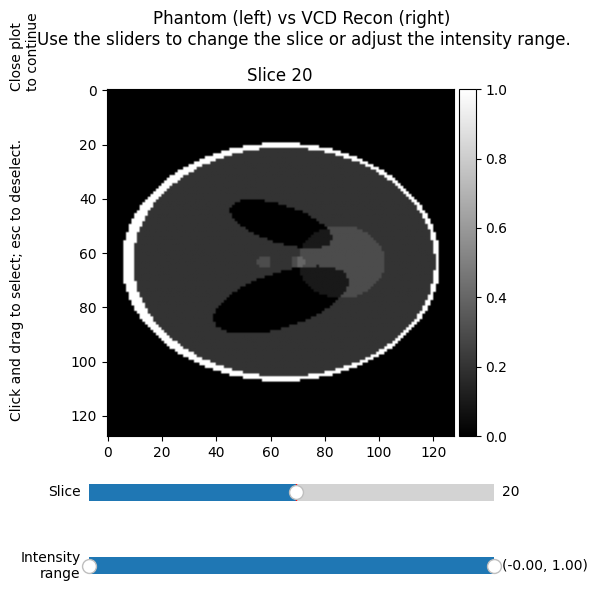

In [3]:
# Display results
title = 'Phantom (left) vs VCD Recon (right) \nUse the sliders to change the slice or adjust the intensity range.'
mbirjax.slice_viewer(phantom,  title=title)


In [13]:
import time
import torch
import numpy as np

def set_sinogram_parameters():
    """Specify sinogram parameters based on user specifications."""
    num_views = 64
    num_det_rows = 40
    num_det_channels = 128
    return num_views, num_det_rows, num_det_channels

@torch.compile
def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles, output_device, worker):
    """Perform batched forward projection."""
    max_views = 16
    max_pixels = 4000
    num_to_exclude = 0

    indices = indices[:len(indices)-num_to_exclude]
    angles = angles.to(worker)

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views)
    view_batch_indices = torch.concatenate([view_batch_indices, torch.tensor([num_views], dtype=torch.int32)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels)
    pixel_batch_indices = torch.concatenate([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32)])

    sinogram = []

    for j, view_index_start in enumerate(view_batch_indices[:-1]):
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end-view_index_start, sinogram_shape[1], sinogram_shape[2]),
                                     device=worker)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        print(f'Starting view batch {j+1} of {len(view_batch_indices)-1}')

        for k, pixel_index_start in enumerate(pixel_batch_indices[:-1]):
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(worker)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(worker)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape, worker)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch.to(output_device))
    sinogram = torch.concatenate(sinogram)
    return sinogram

@torch.compile
def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view,
                                            sinogram_shape, recon_shape, worker):
    """Apply a parallel beam transformation."""
    num_views, num_det_rows, num_det_channels = sinogram_shape
    psf_radius = 1
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in torch.arange(-psf_radius, psf_radius+1):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, torch.zeros(1, device=worker), L_max)
        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clip(n, 0, num_det_channels - 1)
        update = A_chan_n.reshape((1, -1)) * voxel_values.T
        indices = n.expand(num_det_rows, -1).type(torch.int64)
        sinogram_view = sinogram_view.scatter_add(1, indices, update)

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    """Compute projection-related geometry data."""
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

def generate_sinogram():
    """Loads the phantom and runs forward projection, returning the sinogram."""
    num_views, num_det_rows, num_det_channels = set_sinogram_parameters()
    start_angle = 0
    end_angle = torch.pi
    sinogram_shape = (num_views, num_det_rows, num_det_channels)
    step_size = (end_angle - start_angle) / num_views
    angles = torch.linspace(start=start_angle, end=end_angle - step_size, steps=num_views)

    output_device = torch.device("cpu")
    worker = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load phantom from a NumPy file
    phantom_np = np.load("/content/phantom.npy")  # Replace with actual file path
    phantom = torch.tensor(phantom_np, dtype=torch.float32, device=output_device)

    # Ensure phantom shape matches expected reconstruction shape
    recon_shape = (num_det_channels, num_det_channels, num_det_rows)
    if phantom.shape != recon_shape:
        raise ValueError(f"Loaded phantom shape {phantom.shape} does not match expected shape {recon_shape}")

    # Generate indices of pixels and sinogram data
    max_index_val = recon_shape[0] * recon_shape[1]
    indices = torch.arange(max_index_val, dtype=torch.int32)
    voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

    print('Starting forward projection')
    voxel_values.to(output_device)
    indices.to(output_device)
    t0 = time.time()
    sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles,
                                      output_device=output_device, worker=worker)

    print('Elapsed time:', time.time() - t0)
    print(f'Sinogram shape: {sinogram.shape}')

    return sinogram

# Call generate_sinogram() and store the sinogram globally
if __name__ == "__main__":
    sinogram = generate_sinogram()
    # You can now use sinogram outside the function
    print("Sinogram is ready for further processing!")


Starting forward projection
Starting view batch 1 of 4
Starting view batch 2 of 4
Starting view batch 3 of 4
Starting view batch 4 of 4
Elapsed time: 3.8472132682800293
Sinogram shape: torch.Size([64, 40, 128])
Sinogram is ready for further processing!


In [8]:
sinogram.shape

torch.Size([64, 40, 128])

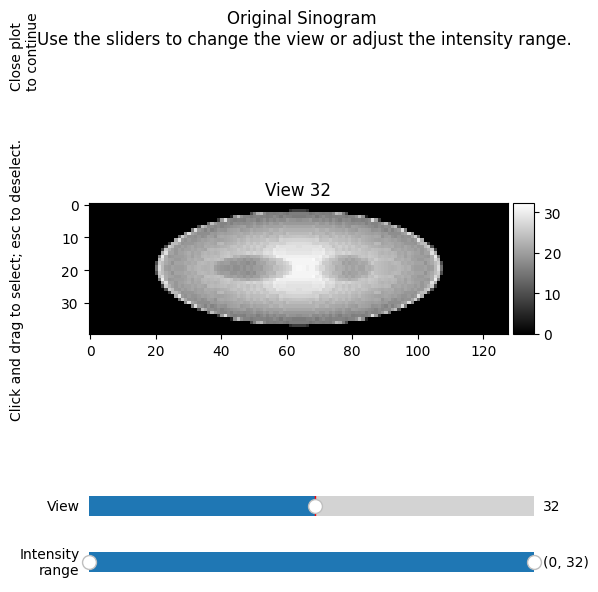

In [9]:
import mbirjax
title = 'Original Sinogram \nUse the sliders to change the view or adjust the intensity range.'
mbirjax.slice_viewer(sinogram.cpu().numpy(), slice_axis=0, title=title, slice_label='View')

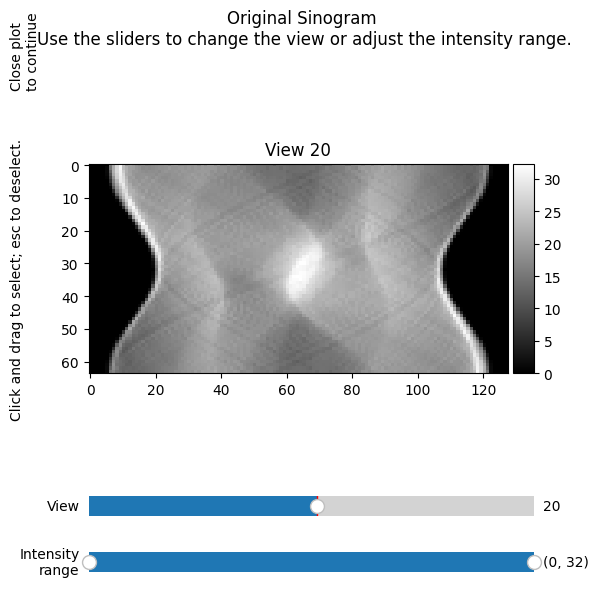

In [10]:
import mbirjax
title = 'Original Sinogram \nUse the sliders to change the view or adjust the intensity range.'
mbirjax.slice_viewer(sinogram.cpu().numpy(), slice_axis=1, title=title, slice_label='View')

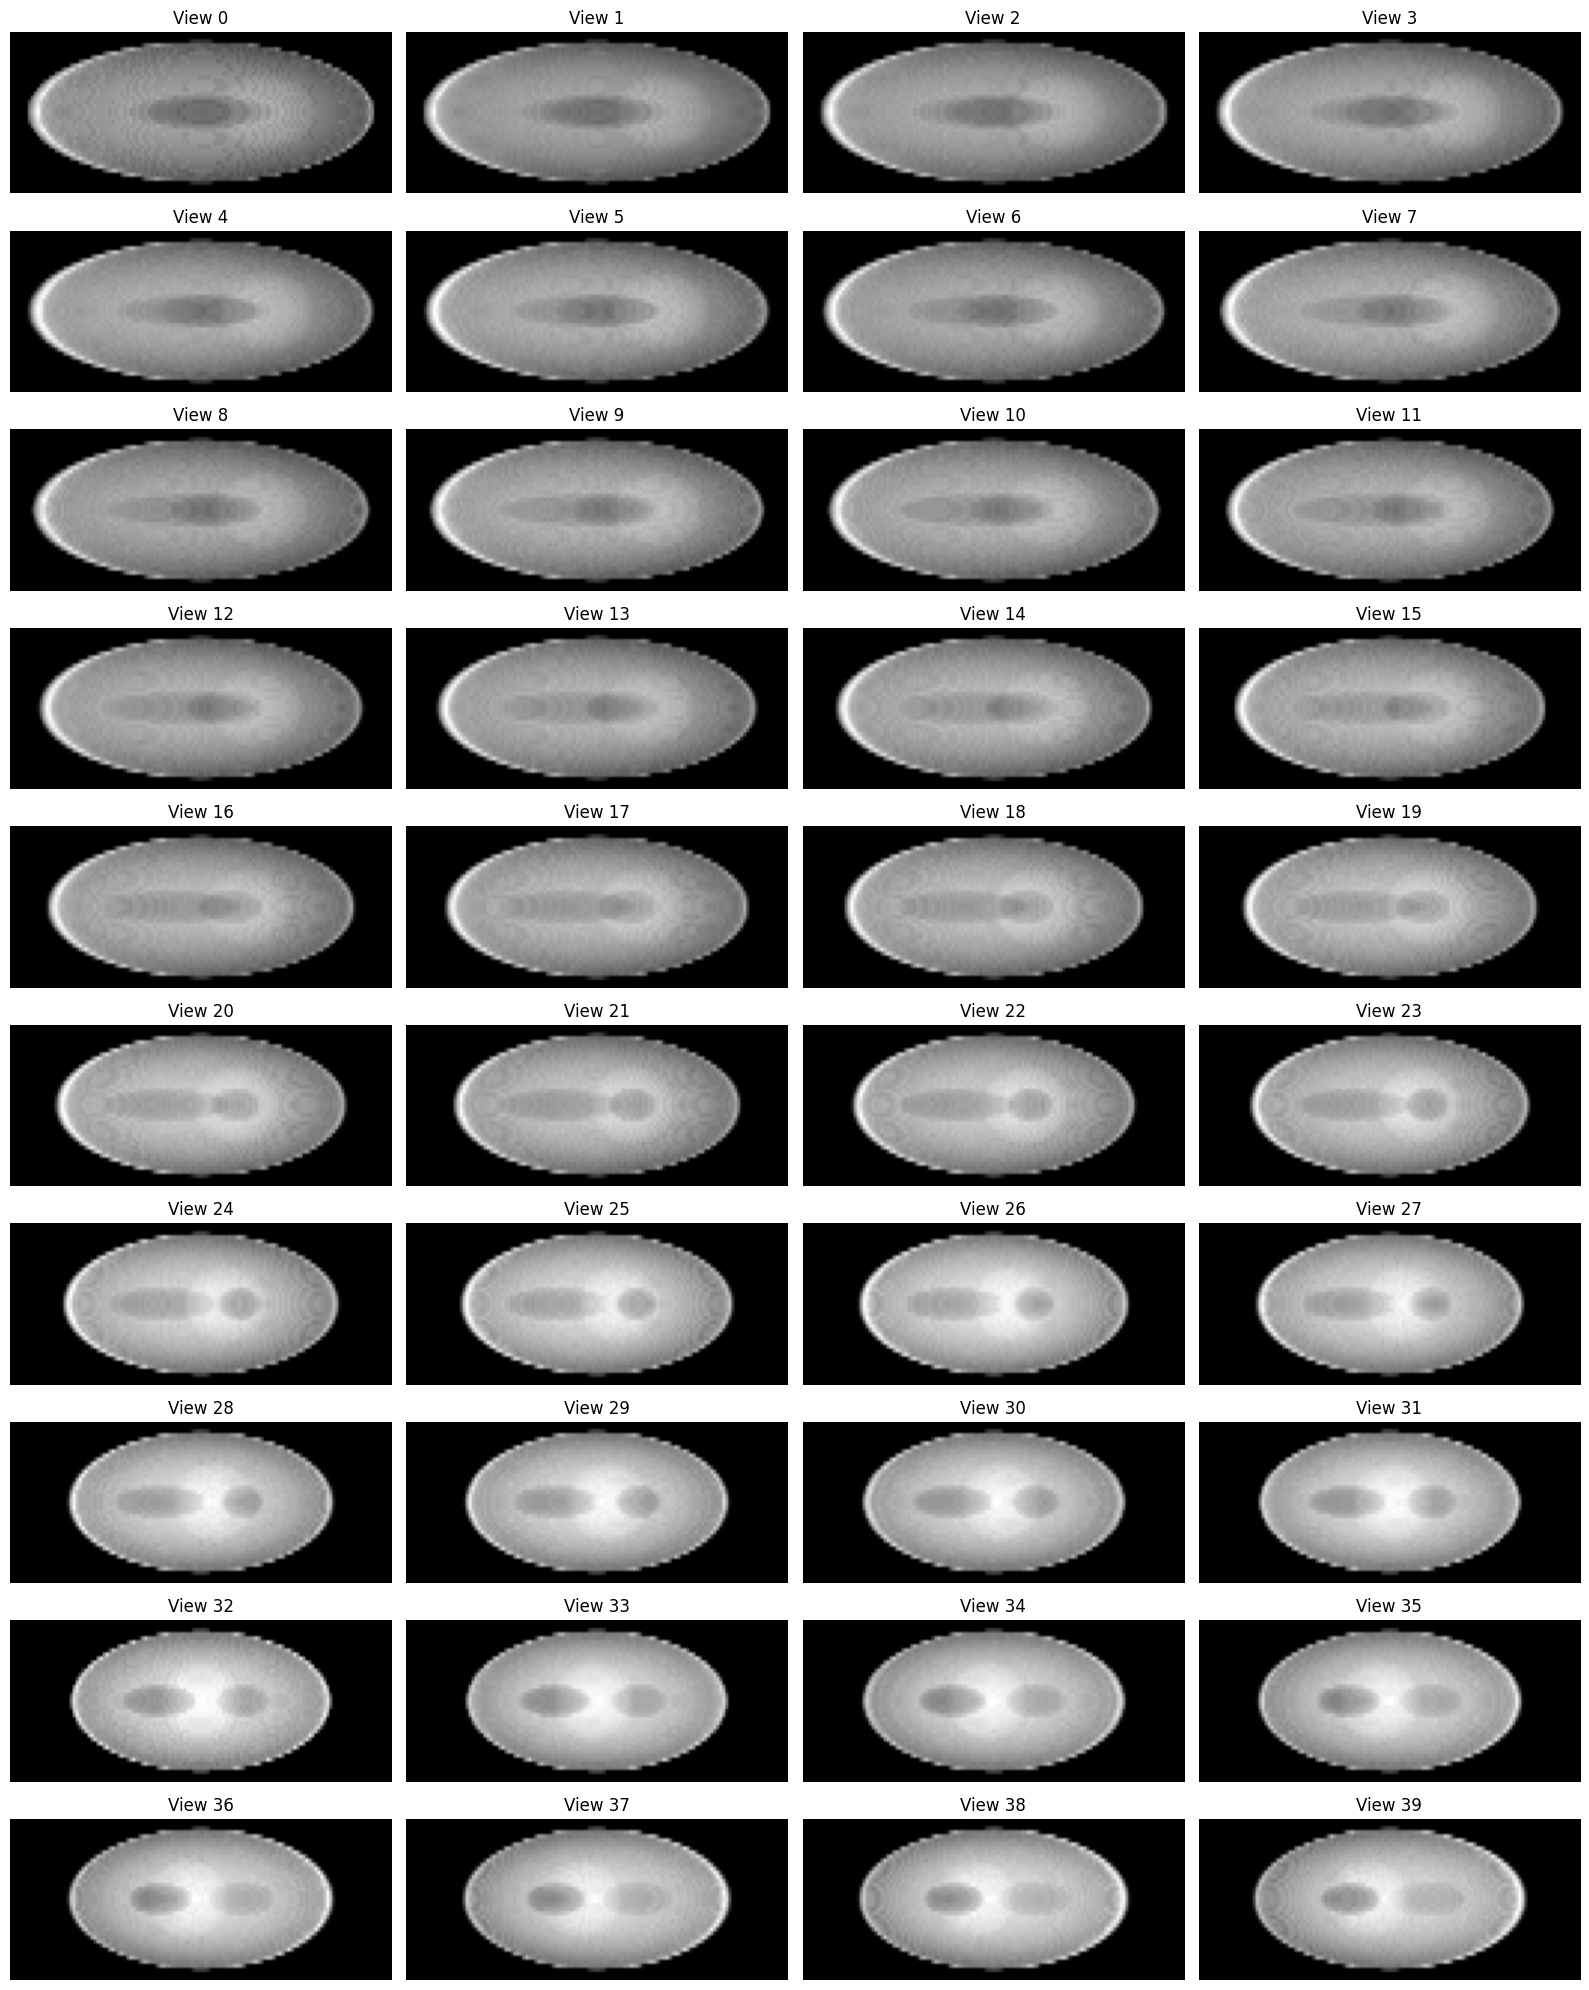

In [11]:
import matplotlib.pyplot as plt

num_views, num_det_rows, num_det_channels = sinogram.shape

# Calculate the number of subplots needed
num_subplots = min(40, num_views)  # Limit to 40 or num_views, whichever is smaller

# Create subplots with enough space for all views
fig, axes = plt.subplots(nrows=num_subplots // 4, ncols=4, figsize=(16, num_subplots // 2))
axes = axes.ravel()  # Flatten to easily iterate over

# Iterate through the desired number of views (limited to 40 or num_views)
for i in range(num_subplots):
    axes[i].imshow(sinogram[i].cpu().numpy(), cmap='gray', aspect='auto')
    axes[i].axis('off')
    axes[i].set_title(f"View {i}")

plt.tight_layout()
plt.show()